# DIGLM Tutorial
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ObKtsBfyd6yFbrRNZcY80BOTdDIUlLPA#scrollTo=FVkNEiOXZYJb)

In this notebook we illustrate with a toy model the usage of the DIGLM class. 

The notebook is organized as follows:

1. Introduction;
2. Creation of a toy dataset;
3. Building the model and defining training functons;
4. Support function for plotting and sampling;
5. Training;
6. Results and final considerations


## 1.  Introduction

An object of the DIGLM class is a trainable model which allows to accomplish the two following tasks:

1. Reproduce the feature distribution thanks to a *normalizing flow* step mapping the features to a latent space with multivariate normal distribution features;
2. Perform regression (linear, logistic and much more) with a Generalized Linear Model (GLM).

The idea comes from the article by [E. Nalisnick et al.](https://arxiv.org/abs/1902.02767) where the DIGLM model and algorithm characteristics is described and test on some examples are provided.

The two parts that constitute the algorithm are trained in a single feed-forward step of a semi-supervised training:
given the features observation $ \{x\}_i ^N $ and their true labels $ \{y\}_i ^N $, the loss function minimized is

$- \sum_i \log{p(y|x; \theta, \beta)} + \lambda \log{p(x; \theta)}$

where:

1. $\beta$ are the weights of the glm;
2. $\theta$ are the parameters that maps the distibution of $x$ to the space of the latent variables $z$ through the *normalizing flow*. The distribution of $z$ is set to be a multivariate normal distribution with dimension equal to the space of the feature vectors;
3. $\lambda$ is a hyper-parameter which weights the importance in the training of the two different parts of the loss: the first term indeed is used to solve the regression problem; the second one trains the *normalizing flow*. 




In [8]:
##### UNCOMMENT TO RUN ON GOOGLE COLAB #####
#! git clone https://github.com/MarcoRiggirello/diglm.git

#import sys
#sys.path.append('diglm/src')
import os
import logging

import tensorflow as tf
from tensorflow import Variable, ones, zeros
from tensorflow_probability import glm
from tensorflow_probability import distributions as tfd
from tensorflow.keras import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from diglm import DIGLM
from spqr import NeuralSplineFlow as NSF


# sinlencing tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## 2. Toy dataset

The feature vectors $x_1$ and $x_2$ are sampled from a uniform distribution $U[-1, 1]$.
The response function $y(x_1, x_2): \mathbb{R}^2 \rightarrow \{0, 1\}$ is:
$
\begin{cases}
1 \text{ if } x_1 \cdot x_2 > \dfrac{1}{x_1 \cdot x_2} \\
0 \text{ elsewise} \\
\end{cases}
$

The sampled vectors and the response are transformed to a `tf.data.Dataset`.

Text(0.5, 1.05, 'Target distribution')

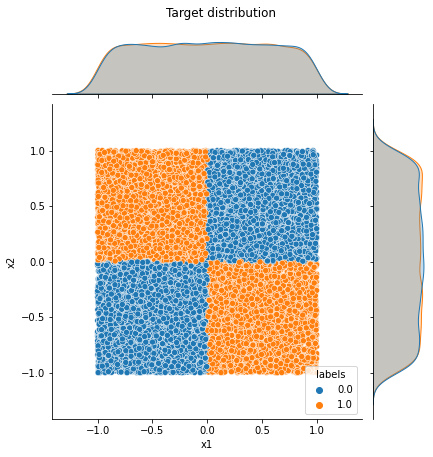

In [9]:
#response function
response = lambda x1, x2: x1 * x2 > 1 / (x1 * x2) 

BATCH_SIZE = 128
DATASET_SIZE = BATCH_SIZE * 128
VAL_SIZE = BATCH_SIZE * 16

# dataset for training
X1 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
X2 = np.random.uniform(low=-1, high=1, size=DATASET_SIZE)
df = pd.DataFrame(np.stack((response(X1, X2), X1, X2), axis=1),
                  columns=['labels','x1', 'x2'])

# dataset for validation
X1_val = np.random.uniform(low=-1, high=1, size=VAL_SIZE)
X2_val = np.random.uniform(low=-1, high=1, size=VAL_SIZE) 
df_val = pd.DataFrame(np.stack((response(X1_val, X2_val), X1_val, X2_val), axis=1),
                  columns=['labels','x1', 'x2'])

# dataset for test
X1_test = np.random.uniform(low=-1, high=1, size=VAL_SIZE)
X2_test = np.random.uniform(low=-1, high=1, size=VAL_SIZE) 
df_test = pd.DataFrame(np.stack((response(X1_test, X2_test), X1_test, X2_test), axis=1),
                  columns=['labels','x1', 'x2'])

# plotting the toy dataset with marginalized feature distribution too
joint_plot = sns.jointplot(data=df, x='x1', y='x2', hue='labels')
joint_plot.figure.suptitle('Target distribution', y = 1.05)

## 3. Utilities: transforming datasets, sampling of distributions and plotting

We define some functions to transform our data into TesnorFlow datasets for automatic batching and parallelization; to extract sample from the transformed distributions and to plot them.

In [10]:
def to_tf_dataset(df, columns, dtype='float32', batch_size=32):
    """
    util function to transform a pandas.DataFrame into a
    batched tf.data.Dataset.
    
    """

    tf_ds = tf.data.Dataset.from_tensor_slices(df[columns].astype(dtype))
    tf_ds = tf_ds.prefetch(tf.data.experimental.AUTOTUNE)
    tf_ds = tf_ds.cache()
    return tf_ds

def sampling(size=500):
    """
    returns a sample of the transformed disribution and its computed
    response through glm evaluation.

    """
    trans_sample = diglm.sample(size)['features']
    mean_sample, var_sample, grad_sample  = diglm(trans_sample)
    x1, x2 = np.split(trans_sample.numpy(), 2, axis=1)
    x1 = np.concatenate(x1)
    x2 = np.concatenate(x2)
    mean = np.concatenate(mean_sample.numpy().T)
    return mean, x1, x2

def plot(name, counter=None): 
    """
    plotting function that gets some samples from the norm. flow
    inverse distribution and the calculated response and plots it
    alongside with the target distribution
    """
    # Get sampling data to plot
    mean, x1, x2 = sampling(size=DATASET_SIZE)
    df_train = pd.DataFrame(np.stack((mean, x1, x2), axis=1),
                            columns=['labels', 'x1', 'x2'])
    #plot
    #fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # training data samples
    ax_1 = sns.scatterplot(data=df_train, x='x1', y='x2', hue='labels', palette='coolwarm')
    sns.histplot(data=df, x='x1', y='x2', hue='labels', alpha=0.5, ax=ax_1)
    # target distribution
    #sns.scatterplot(data=df, x='x1', y='x2', hue='labels', ax=ax_2)
    ax_1.set_ylim(min(x1), max(x1))
    ax_1.set_xlim(min(x1), max(x2))
    if counter is not None: # used to track the training epoch
        ax_1.set_title(f'Training epoch = {counter}')
    #ax_2.set_title('Target distribution')

    plt.savefig(name) 

train_ft = to_tf_dataset(df, ['x1', 'x2'], batch_size=BATCH_SIZE)
train_l = to_tf_dataset(df, ['labels'], dtype='int32', batch_size=BATCH_SIZE)

val_ft = to_tf_dataset(df_val, ['x1', 'x2'], batch_size=VAL_SIZE)
val_l = to_tf_dataset(df_val, ['labels'], dtype='int32', batch_size=VAL_SIZE)

test_ft = to_tf_dataset(df_test, ['x1', 'x2'], batch_size=VAL_SIZE)
test_l = to_tf_dataset(df_test, ['labels'], dtype='int32', batch_size=VAL_SIZE)

## 4. Building the DIGLM 

We initialize our diglm model with:

1. a NeuralSplineFlow object as bijector with two splits (there are only two variables
2. a `tf.glm.Bernoulli()` as glm to realize the logistic regression.


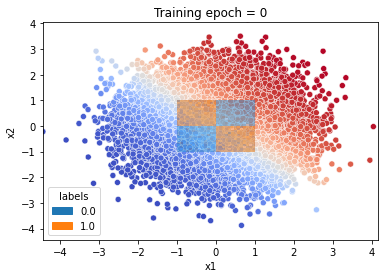

In [11]:
my_glm = glm.Bernoulli()
neural_spline_flow = NSF(splits=2)
diglm = DIGLM(neural_spline_flow, my_glm, 2)

train_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(train_l, train_ft)]
val_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(val_l, val_ft)]
test_dict = [{'labels': batch_l,
              'features': batch_ft}
              for batch_l, batch_ft in zip(test_l, test_ft)]


# let's visualize a sample from the inverse distribution of the bijector
# before training.
plot('start.jpeg', counter=0)

## 5. Training

First, we define a train step, where the loss and its gradient are calculated and the training variables of the model are updated accordingly. We follow the [keras tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

In [12]:
@tf.function
def train_step(optimizer, target_sample, val_sample, weight=.1):
    """
    Train step function for the diglm model. Implements the basic steps for computing
    and updating the trainable variables of the model. It also
    calculates the loss on training and validation samples.

    """

    with tf.GradientTape() as tape:
        # calculating loss and its gradient of training data
        loss = -tf.reduce_mean(diglm.weighted_log_prob(target_sample, scaling_const=weight))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    # validation loss estimate
    val_loss = -tf.reduce_mean(diglm.weighted_log_prob(val_sample, scaling_const=weight))
    return loss, val_loss

Now we are ready to train the model!

In [ ]:
# we define a suitable metric
accuracy = metrics.BinaryAccuracy()

def update_accuracy():
    """
    util function to update the binary accuracy metric
    to evaluate the algorithm performances.
    """
    accuracy.reset_state()
    y_true = val_dict[0]['labels']
    y_pred, y_var, grad = diglm(val_dict[0]['features'])
    accuracy.update_state(y_true, y_pred.numpy().T)
    history['accuracy'].append(accuracy.result().numpy())

# hyper parameters
LR = 1e-3
NUM_EPOCHS = 25
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
val_loss = 0
history = {'accuracy': [], 'train_loss': [], 'val_loss': []}
fig_list = []

weight = 0.1

# training loop on epochs
for epoch in range(NUM_EPOCHS):
    # plot
    name = f'fig{epoch}.jpeg'
    fig_list.append(name)
    plot(name, counter=(epoch + 1))
    plt.close()
    print(f'Epoch = {epoch+1} \t Loss = {loss:.3f} \t Val loss = {val_loss:.3f}')
    # train batch per batch
    for i, batch in enumerate(train_dict):
        loss, val_loss = train_step(optimizer, batch, val_dict[0], weight=weight)
       # updating loss and accuracy
        update_accuracy()
        history['train_loss'].append(loss)
        history['val_loss'].append(val_loss)

Epoch = 1 	 Loss = 0.000 	 Val loss = 0.000


## 6. Results

To illustrate the results of the training, we plot:

1. a gif illustrating how the algorithm learnt both to reproduce the feature distribution and the response
2. The loss and accuracy history


In [43]:
from plot_utils import make_gif

make_gif(fig_list, "diglm_example.gif", duration=0.3)

[SegmentLocal](diglm_example.gif 'segment')

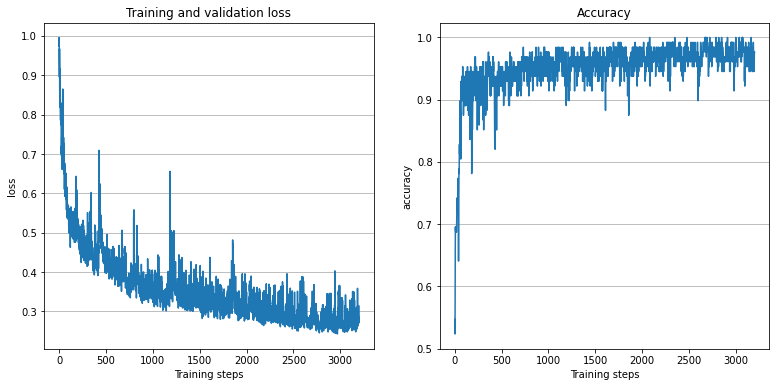

In [47]:
# loss plot
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.title('Training and validation loss')
plt.plot([i for i in range(len(history['loss'])-1)],
        history['loss'][1:],
        label='train loss')
plt.plot([i for i in range(len(history['loss'])-1)],
        history['val_loss'][1:],
        label='val loss')
plt.xlabel('Training steps')
plt.ylabel('loss')
plt.grid(axis='y')

# accuracy plot
plt.subplot(122)
plt.title('Accuracy')
plt.plot([i for i in range(len(history['accuracy']))],
        history['accuracy'])
plt.xlabel('Training steps')
plt.ylabel('accuracy')
plt.grid(axis='y')

Referring to the gif, we see that the algorithm accomplished the task of evaluating the dataset feature distribution as well as the response function. The quality of the response evaluation is monitored through the `BinaryAccuracy` metric, counting the fraction:

\begin{equation}
\dfrac{\text{True Positive + True Negative}}{\text{All}}
\end{equation}

where the Positive / Negative cut on the response function is set to 0.5. After 25 epochs, the loss function attains a *plateau* and the accuracy is stably around 0.97. 

Just as in the SpQR notebook, we can evaluate the quality of the feature distribution evaluation using a Kolmogorov-Smirnov test

In [49]:
from scipy.stats import ks_2samp


#slicing and preparing arrays to perform the test
mean, x1_trans, x2_trans = sampling(1000)
mean_target, x1_target, x2_target = np.squeeze(np.split(df.to_numpy(), 3, axis=1))

# calculating statistic from K-S test and p-values
stat_1, pval_1 = ks_2samp(x1_trans, x1_target)
stat_2, pval_2 = ks_2samp(x2_trans, x2_target)

print(f'p-value x1 distribution = {pval_1}')
print(f'p-value x2 distribution = {pval_2}')

p-value x1 distribution = 8.102245623690368e-21
p-value x2 distribution = 8.602278256074017e-09


### About $\lambda$

The hyper-parameter $\lambda$ weights the two component of the log-likelihood loss, favouring the training of one part of the algorithm over the other. Changing this hyper-parameter to 0.5 and 1.0, we saw that the training incurred in overfitting, therefore a reduction of the learning rate was required to obtain good performances.